In [1]:
import sys
sys.path.append("../src")

import homography

e:\Programming\Learning\Brand-Detection\test_impl\../src\homography.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  if s[0] / s[1] > max_scale or s[1] / s[0] > max_scale:



DEBUG RANSAC:
  Total points: 17
  Inliers: 5/17
CV2 RANSAC:
  Inliers: 7/17
  Homography matrix:
[[-3.03357156e-01 -1.25692781e+00  8.03014154e+02]
 [-2.03509733e-02 -6.19300715e-02  4.40918770e+01]
 [-3.76126303e-04 -1.56836852e-03  1.00000000e+00]]

My RANSAC:
  Inliers: 0/17
  Homography matrix:
None



TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

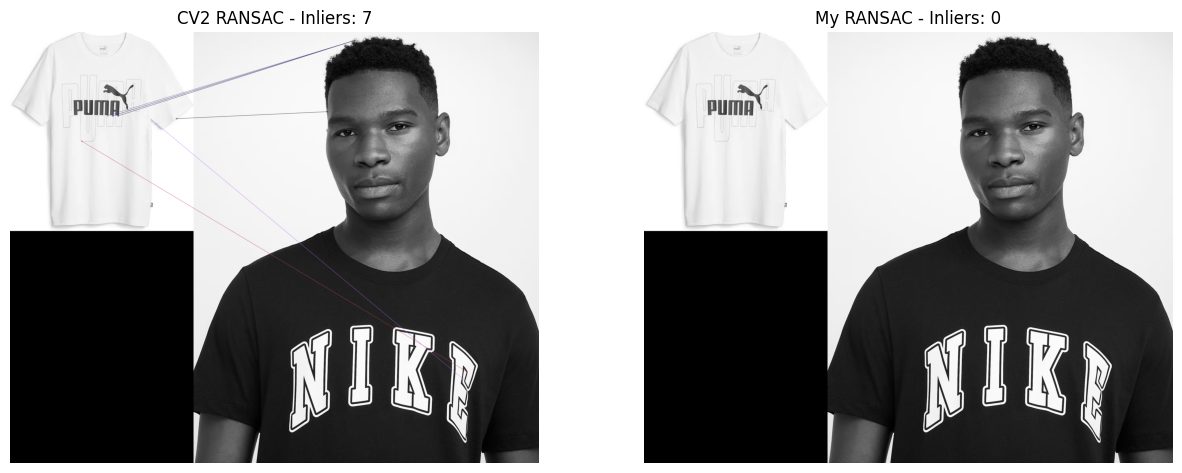

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
# Assuming you have matched keypoints from two images
# src_pts and dst_pts should be arrays of corresponding points

# Example: Load two images and find matches (if you haven't already)
img1 = cv2.imread("../Cloth/a3.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("../Cloth/nike_shirt2.png", cv2.IMREAD_GRAYSCALE)

# Detect keypoints and compute descriptors (using SIFT or ORB)
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Match features
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extract matched keypoints
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

H, mask = homography.ran_sac(src_pts, dst_pts, threshold=5.0, confidence=0.99)

print(f"\nDEBUG RANSAC:")
print(f"  Total points: {len(src_pts)}")
print(f"  Inliers: {np.sum(mask)}/{len(src_pts)}")


# OpenCV RANSAC
H_cv2, mask_cv2 = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Your custom RANSAC (fix the typo: dsy_pts -> dst_pts)
H_mine, mask_mine = homography.ran_sac(src_pts, dst_pts, threshold=5.0, confidence=0.99)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 12))

# Draw matches for CV2 RANSAC
img_matches_cv2 = cv2.drawMatches(
    img1, kp1, img2, kp2, 
    [good_matches[i] for i in range(len(good_matches)) if mask_cv2[i]], 
    None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Draw matches for Your RANSAC
img_matches_mine = cv2.drawMatches(
    img1, kp1, img2, kp2, 
    [good_matches[i] for i in range(len(good_matches)) if mask_mine[i]], 
    None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Plot CV2 results
axes[0].imshow(cv2.cvtColor(img_matches_cv2, cv2.COLOR_BGR2RGB))
axes[0].set_title(f"CV2 RANSAC - Inliers: {np.sum(mask_cv2)}")
axes[0].axis('off')

# Plot Your results
axes[1].imshow(cv2.cvtColor(img_matches_mine, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"My RANSAC - Inliers: {np.sum(mask_mine)}")
axes[1].axis('off')


# Print comparison statistics
print(f"CV2 RANSAC:")
print(f"  Inliers: {np.sum(mask_cv2)}/{len(mask_cv2)}")
print(f"  Homography matrix:\n{H_cv2}\n")

print(f"My RANSAC:")
print(f"  Inliers: {np.sum(mask_mine)}/{len(mask_mine)}")
print(f"  Homography matrix:\n{H_mine}\n")

if H_cv2 is None:
    print(f"H_cv is None while mine is \n{H_mine}.")
else:   
    print(f"Homography difference (Frobenius norm): {np.linalg.norm(H_cv2 - H_mine)}")